In [1]:
# Import from Standard Library
import logging
import os
import pathlib
import subprocess
import warnings
from glob import glob

# Import from Third Party Libraries
import earthpy.appeears as etapp
import folium
import geopandas as gpd
import hvplot.pandas
import hvplot.xarray
import matplotlib.pyplot as plt
import pandas as pd
import rioxarray as rxr
import xarray as xr


# Set up logging so AppeearsDownloader will log in notebook
logging.basicConfig(level=logging.INFO)

# Ignore FutureWarning coming from hvplot
warnings.simplefilter(action='ignore', category=FutureWarning)

# Ignore warnings
warnings.filterwarnings("ignore")

# Rim Fire in Stanislaus National Forest, California


<figure style="display: inline-block; border: 1px dotted gray; margin: 20px;">
    <img alt="Rim Fire and American Fire large" src="https://upload.wikimedia.org/wikipedia/commons/thumb/4/47/Rim_Fire_and_American_Fire_large.jpg/256px-Rim_Fire_and_American_Fire_large.jpg" style="float:left; height: 500px; vertical-align: top;"/>
    <figcaption style="text-align: center; height: 400px; vertical-align: top" > Aug 22, 2013 Image from MODIS
        <br><a href="https://upload.wikimedia.org/wikipedia/commons/thumb/4/47/Rim_Fire_and_American_Fire_large.jpg/256px-Rim_Fire_and_American_Fire_large.jpg">Jeff Schmaltz</a>, Public domain, via Wikimedia Commons
        </figcaption>
</figure>

<figure style="display: inline-block; border: 1px dotted gray; margin: 20px;">
    <img alt="Rim Fire and American Fire large" src="https://upload.wikimedia.org/wikipedia/commons/f/f3/The_Rim_Fire_in_the_Stanislaus_National_Forest_on_Aug._17%2C_2013_-001.jpg" style="float:left; height: 500px; vertical-align: top;"/>
    <figcaption style="text-align: center; height: 400px; vertical-align: top" >Rim Fire
        <br><a href="https://upload.wikimedia.org/wikipedia/commons/f/f3/The_Rim_Fire_in_the_Stanislaus_National_Forest_on_Aug._17%2C_2013_-001.jpg">US Gov</a>, Public domain, via Wikimedia Commons
        </figcaption>
</figure>

### Site Description:
* The Rim Fire began in Stanislaus National Forest on August 17, 2013.
* 257,314 acres were affected. 
* Most of the affected land was burned in the first week of the fire. The fire was fully contained by the end of October 2013 but not declared out until 2014.

For more information:
* https://www.esa.org/esablog/2014/08/05/the-rim-fire-one-year-later-a-natural-experiment-in-fire-ecology-and-management/


### Data Description:
* Data consists of MODIS NDVI values for the summer months from 2012 to 2023. As the first began in mid-August 2013, the 2012 data represents the last year pre-fire. 2014 data was the first full summer post-fire, since the fire began in mid-August 2013.
* The boundary for the fire was obtained from the National Interagency Fire Center.

### Map of Rim Fire
* A map of the affected area is below. The approximate starting location is shown, as well as the Rim of the World vist for which the fire was named.

In [2]:
# Define File Path For Data
rimfire_path = os.path.join(pathlib.Path.home(),
                             'earth-analytics', 'data', 'rimfire_data')

# Create Directory Using Path
os.makedirs(rimfire_path, exist_ok=True)


In [3]:
# Import Rim Fire Boundary
rimfire_bnd_gdf = gpd.read_file(
    "https://services3.arcgis.com/T4QMspbfLg3qTGWY/arcgis/rest/services"
    "/Historic_Geomac_Perimeters_Combined_2000_2018/FeatureServer/0/query"
    "?where=incidentname%20%3D%20'RIM'%20AND%20%20"
    "(fireyear%20%3D%202013%20OR%20fireyear%20%3D%202014)%20"
    "&outFields=*&outSR=4326&f=json")


In [4]:
# Define Fire Start Location and Rim of the World Site
fire_st_lat = 37.865528
fire_st_lon = -120.116944

rotw_lat = 37.821905
rotw_lon = -120.039025

# Create Map
m = folium.Map(location=(fire_st_lat, fire_st_lon + .2), 
               tiles=None,
               zoom_start=10)

# Convert data to JSON
rimfire_bnd_json = rimfire_bnd_gdf.to_json()

# Add fire boundary to map
folium.GeoJson(rimfire_bnd_json).add_to(m)

# Add approximate starting location
folium.Marker(location=[fire_st_lat, fire_st_lon],
      popup="Approximate Start Location",
      ).add_to(m)

# Add Rim of the World Vista Point Location
folium.Marker(location=[rotw_lat, rotw_lon],
      popup="Rim of the World Vista Point"
      ).add_to(m)

# Add ESRI World Imagery (Source: https://gis.stackexchange.com/
# questions/290861/python-folium-package-for-satellite-map)
tile = folium.TileLayer(
        tiles = ('https://server.arcgisonline.com/ArcGIS/rest/services/'
        'World_Imagery/MapServer/tile/{z}/{y}/{x}'),
        attr = 'Esri',
        name = 'Esri Satellite',
        overlay = False,
        control = True
       ).add_to(m)

m


In [5]:
# Initialize AppeearsDownloader for MODIS NDVI data
ndvi_downloader = etapp.AppeearsDownloader(
    download_key="modis-ndvi",
    ea_dir=rimfire_path,
    product="MYD13Q1.061",
    layer="_250m_16_days_NDVI",
    start_date="06-01",
    end_date="08-31",
    recurring=True,
    year_range=[2012, 2012],
    polygon=rimfire_bnd_gdf,
)

# Download files if the download directory does not exist
if not os.path.exists(ndvi_downloader.data_dir):
    ndvi_downloader.download_files()


In [6]:
# Print all dirs found by glob
data_dirs = os.path.join(rimfire_path, "*")
all_dirs = glob(data_dirs)
# Nesting for loops
rimfire_files = []
for a_dir in all_dirs:
    dir_path = os.path.join(a_dir, "*")
    all_file_paths = (glob(dir_path))
    # Create a nested loop which loops through each directory
    for a_file_path in all_file_paths:
       rimfire_files.append(a_file_path)
rimfire_files_sort = sorted(rimfire_files)
# rimfire_files_sort

# glob(ndvi_downloader.data_dir)

In [7]:
# Create List of NDVI tif files
ndvi_path_lst = glob(os.path.join(ndvi_downloader.data_dir, "*", "*NDVI*.tif"))


In [8]:
# Define Day of Year start and end locations in file names
doy_start = -19
doy_end = -12

# Define Scale Factor
scale_factor = 10000

# Create empty list for NDVI files
ndvi_da_list = []

# Loop through each ndvi file
for ndvi_path in ndvi_path_lst:
    # Get date from file name
    doy = ndvi_path[doy_start:doy_end]
    date = pd.to_datetime(doy, format='%Y%j')
    # Open dataset
    da = rxr.open_rasterio(ndvi_path, masked=True).squeeze()

    # Prepare to concatenate: Add date dimension and clean up metadata
    da = da.assign_coords({'date': date})
    da = da.expand_dims({'date': 1})
    da.name = 'NDVI'

    # Divide by scale factor
    da = da / scale_factor
    # Add the DataArray to the end of the accumulator list
    ndvi_da_list.append(da)

In [9]:
# Combine data files
ndvi_ds = xr.combine_by_coords(ndvi_da_list, coords=['date'])


### There were substantial losses of vegetation with the affected area from before the fire (2012) to after the fire (2014).

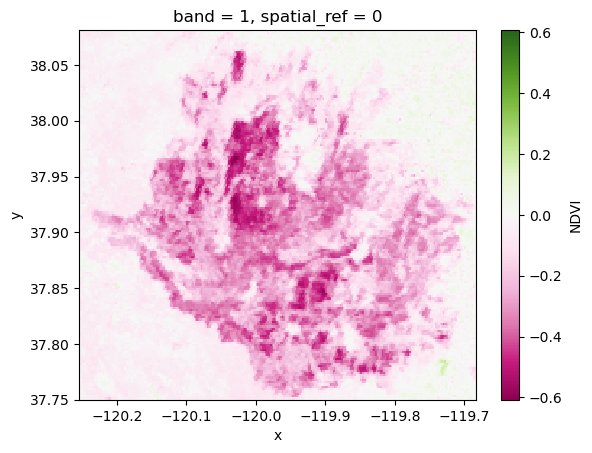

In [10]:
# Get mean NDVI data for 2012
ndvi_2012_da = (ndvi_ds
    .sel(date='2012')
    .mean('date')
    .NDVI
)

# Get mean NDVI data for 2014
ndvi_2014_da = (ndvi_ds
    .sel(date='2014')
    .mean('date')
    .NDVI
)

# Get difference between 2012 and 2014
ndvi_diff_da = ndvi_2014_da - ndvi_2012_da

# Plot difference in NDVI data
ndvi_diff_da.plot(cmap=plt.colormaps['PiYG'])

# # Add Campfire boundary
# rimfire_bnd_gdf.plot(ax=plt.gca(), facecolor='none')
# plt.title("Change in NDVI from 2012 to 2014")
# plt.ylabel('Latitude')
# plt.xlabel('Longitude')
# plt.xticks(fontsize=8)
# plt.yticks(fontsize=8)
# plt.savefig('ndvi_12_to_14.png')

### A decade after the fire, NDVI remains lower in most areas affected by the Rim Fire. 
* NDVI largely remains lower than pre-fire, though less notably so than in 2014. This indicates partial recovery of vegetation.
* A few small areas exhibited increased NDVI as compared to before the fire, meaning there is more healthy vegetation than before the fire.

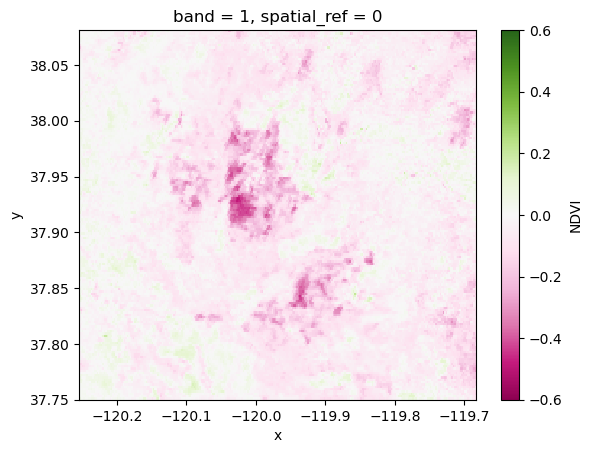

In [11]:
# Get mean NDVI data for 2023
ndvi_2023_da = (ndvi_ds
    .sel(date='2023')
    .mean('date')
    .NDVI
)

# Get difference between 2023 and 2017
ndvi_diff_da = ndvi_2023_da - ndvi_2012_da

# Plot difference in NDVI data
ndvi_diff_da.plot(cmap=plt.colormaps['PiYG'], vmin=-.6, vmax=.6)

# # Add Campfire boundary
# rimfire_bnd_gdf.plot(ax=plt.gca(), facecolor='none')
# plt.title("Change in NDVI from 2012 to 2023")
# plt.ylabel('Latitude')
# plt.xlabel('Longitude')
# plt.xticks(fontsize=8)
# plt.yticks(fontsize=8)
# plt.savefig('ndvi_12_to_23.png')


In [12]:
# Get area outside of Rim Fire
out_gdf = (
    gpd.GeoDataFrame(geometry=rimfire_bnd_gdf.envelope)
    .overlay(right=rimfire_bnd_gdf, how="difference")
)


In [13]:
# Clip Campfire data to boundary
ndvi_fire_ds = ndvi_ds.rio.clip(rimfire_bnd_gdf.geometry)

# Clip area outside of Campfire
ndvi_out_ds = ndvi_ds.rio.clip(out_gdf.geometry)

In [14]:
# Define function to get dataframe of mean NDVI by year
def df_annual_ndvi(indata):
    return (
        indata.groupby(indata.date.dt.year)
        .mean(...)
        .NDVI.to_dataframe()[["NDVI"]]
    )

# Create dataframe of NDVI for Campfire area
ndvi_fire_df = df_annual_ndvi(ndvi_fire_ds)

# Create dataframe of NDVI for the area outside Campire
ndvi_out_df = df_annual_ndvi(ndvi_out_ds)

# Calculate Difference between Dataframes & Save to Dataframe
ndvi_fire_df['Difference'] = (ndvi_fire_df - ndvi_out_df)



### NDVI within the fire boundary has increased since the fire. However, it is yet to reach pre-fire levels ten years later.

* After the Rim Fire, NDVI in the area declined due to the loss of vegetation
* Over the decade since the fire, NDVI has steadily increased. As of 2023, about two-thirds of the lost NDVI has been re-gained. 


In [15]:
# Plot NDVI Change
ndvi_fire_df.NDVI.hvplot(
    title="Summer NDVI in Rim Fire Area",
    xlabel="Year",
    ylabel="Summer NDVI")

# # Trying to add vertical line
# import datetime

# camp_date= datetime.datetime(2018, 11, 8)

# # Start of Year in Ordinal Format
# start_date = datetime.datetime(2018, 1, 1).toordinal()

# # Length of Year
# year_len = datetime.date(2019, 1, 1).toordinal() - start_date

# # Camp Fire Date in Ordinal Format
# camp_date_ord = camp_date.year + (camp_date.toordinal() - start_date) / year_len
# camp_date_ord

# # Plot with vertical line
# plt.plot(ndvi_fire_df.reset_index()["year"], ndvi_fire_df["Difference"])
# plt.axvline(x=camp_date_ord, color='red', ls='--')
# plt.show()

:Curve   [year]   (NDVI)

### NDVI in the affected area has returned to being higher than NDVI in surrounding areas, though not to the same extent.
* Prior to the 2013 Rim Fire, NDVI in the affected area was higher than in the surrounding areas, meaning this area had more healthy vegetation.
* After the fire, surrounding areas had higher NDVI and more healthy vegetation.
* As of 2023, NDVI in the area is once again higher than surrounding area though not to the extent it was pre-fire.

In [16]:
# Difference Plot
ndvi_fire_df.Difference.hvplot(
    title="Difference between Summer NDVI inside and outside Rim Fire area ",
    xlabel="Year",
    ylabel="Summer NDVI")

:Curve   [year]   (Difference)

In [17]:

ndvi_fire_df['NDVI']

ndvi_fire_df['NDVI'].max() - ndvi_fire_df['NDVI'].min()

ndvi_fire_df = ndvi_fire_df.reset_index() 

In [18]:

ndvi_2023 = ndvi_fire_df[ndvi_fire_df['year'] == 2023].NDVI.values[0]
ndvi_2014 = ndvi_fire_df[ndvi_fire_df['year'] == 2014].NDVI.values[0]
ndvi_2012 = ndvi_fire_df[ndvi_fire_df['year'] == 2012].NDVI.values[0]

loss = ndvi_2012 - ndvi_2014
gain = ndvi_2023 - ndvi_2014
per_regain = gain / loss * 100



In [19]:
diff_2023 = ndvi_fire_df[ndvi_fire_df['year'] == 2023].Difference.values[0]
diff_2014 = ndvi_fire_df[ndvi_fire_df['year'] == 2014].Difference.values[0]
diff_2012 = ndvi_fire_df[ndvi_fire_df['year'] == 2012].Difference.values[0]

diff_loss = diff_2012 - diff_2014
diff_gain = diff_2023 - diff_2014
diff_per_regain = diff_loss / diff_gain * 100



In [20]:
%%capture
%%bash
jupyter nbconvert rim_fire_NDVI_change.ipynb --to html --no-input